In [1]:
# Development cell: it automatically reloads modified code in the various modules
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import numpy as np
import sympy as sp

sp.init_printing()

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
import numpy as np
from scipy.stats import ncx2
from scipy.integrate import simpson, cumulative_trapezoid
from scipy.signal import fftconvolve
from scipy.interpolate import splrep, splev
import matplotlib.pyplot as plt  # For visualization

def ComputeNCGenChi2(A, nu, C, Y_sample=None, Lambdas=None, Etas=None,
                     dx_factor=2**11, max_factor=2**4, num_points=2**7):
    """
    Plots a comparison between the histogram of Y_sample (quadratic form Y = X^T A X)
    and the theoretical PDF obtained via multi-convolution of non-central chi-squared components
    (equivalent to inverse FT of the characteristic function PhiY). Returns B-spline representations
    of the PDF and CDF for further use.
    Parameters:
    -----------
    A : np.ndarray
        Symmetric positive semi-definite matrix for the quadratic form.
    nu : np.ndarray
        Mean vector of the multivariate normal X ~ N(nu, C).
    C : np.ndarray
        Covariance matrix of X (positive semi-definite).
    Y_sample : np.ndarray
        Array of samples of Y = X @ (A @ X) for comparison.
    Lambdas : np.ndarray, optional
        Eigenvalues of S.T @ A @ S (precomputed for efficiency). If None, computed internally.
    Etas : np.ndarray, optional
        Transformed non-centrality parameters. If None, computed internally.
    dx_factor : int, default=2000
        Factor for grid spacing: dx = std_y / dx_factor. Higher values yield finer grids
        (better accuracy but slower computation); adjust for higher dim.
    max_factor : float, default=10
        Multiplier for tail truncation: grid up to mean_comp + max_factor * std_comp.
        Controls how far into the tails to integrate each component PDF.
    num_points : int, default=100
        Number of bins/points for the histogram and PDF evaluation grid.
    Returns:
    --------
    tck_pdf : tuple
        B-spline representation (t, c, k) of the PDF (use splev to evaluate).
    tck_cdf : tuple
        B-spline representation (t, c, k) of the CDF (use splev to evaluate).
    """
    dim = A.shape[0]
    # Compute Lambdas and Etas if not provided
    if Lambdas is None or Etas is None:
        Lambda_C, O_C = np.linalg.eigh(C)  # Use eigh for symmetric
        # FIXED: Correct sqrt(C) = O_C @ diag(sqrt(Lambda_C)) @ O_C.T
        S = O_C @ np.diag(np.sqrt(Lambda_C)) @ O_C.T
        Sm1 = np.linalg.inv(S)
        Lambdas, P = np.linalg.eigh(S.T @ A @ S)  # Assume A symmetric
        Etas = P.T @ Sm1 @ nu
    # Compute scales and ncs from the transformation (general for any dim)
    scales = Lambdas
    ncs = Etas ** 2
    # Theoretical mean (and var for std_y)
    mean_y = np.trace(A @ C) + nu @ A @ nu
    var_y = 2 * np.trace((A @ C)**2) + 4 * (nu @ A @ C @ A @ nu)
    std_y = np.sqrt(var_y)
    # PDF via multi-convolution (generalized for any dim)
    dx = std_y / dx_factor if std_y > 0 else 0.01
    mean_comps = scales * (1 + ncs)
    var_comps = 2 * scales**2 * (1 + 2 * ncs)
    dim = len(scales)
    grid_comps = []
    pdf_comps = []
    for k in range(dim):
        std_k = np.sqrt(var_comps[k]) if var_comps[k] > 0 else 1
        max_k = mean_comps[k] + max_factor * std_k
        # FIXED: Start grid at dx/2 > 0 to avoid inf at x=0
        if max_k > dx / 2:
            grid_k = np.arange(dx / 2, max_k + dx / 2, dx)
        else:
            grid_k = np.array([dx / 2])  # Minimal grid if tiny component
        pdf_k = ncx2.pdf(grid_k, df=1, nc=ncs[k], scale=scales[k])
        # Safeguard: Clip extremes to prevent overflow in rare cases
        pdf_k = np.clip(pdf_k, 0, 1e300)
        integ = simpson(pdf_k, grid_k)
        if integ > 0:
            pdf_k /= integ
        grid_comps.append(grid_k)
        pdf_comps.append(pdf_k)
    # Successive convolution
    if dim > 0:
        total_pdf = pdf_comps[0].copy()
        total_grid = grid_comps[0].copy()
        for j in range(1, dim):
            next_pdf = pdf_comps[j]
            dx_check = total_grid[1] - total_grid[0]
            conv = fftconvolve(total_pdf, next_pdf) * dx_check
            new_len = len(total_pdf) + len(next_pdf) - 1
            total_pdf = conv
            total_grid = np.linspace(0, (new_len - 1) * dx_check, new_len)
            # Clip after conv to stay safe
            total_pdf = np.clip(total_pdf, 0, 1e300)
        # Renormalize
        integ = simpson(total_pdf, total_grid)
        if integ > 0:
            total_pdf /= integ
        else:
            total_pdf = np.array([])
            total_grid = np.array([])
    else:
        total_pdf = np.array([1.0])  # Degenerate case: delta at 0
        total_grid = np.array([0.0])
    # Fit B-spline to PDF
    if len(total_grid) > 3:
        tck_pdf = splrep(total_grid, total_pdf, s=0, k=3)  # Cubic B-spline interpolation
    else:
        tck_pdf = None
    # Compute CDF via cumulative trapezoidal integration and fit B-spline
    if len(total_grid) > 1 and tck_pdf is not None:
        cdf_vals = cumulative_trapezoid(total_pdf, total_grid, initial=0)
        # Normalize to ensure CDF(end) ≈ 1
        if len(cdf_vals) > 0:
            cdf_vals[-1] = 1.0
        tck_cdf = splrep(total_grid, cdf_vals, s=0, k=3)
    else:
        tck_cdf = None
    # Plot comparison
    if Y_sample is not None:
        # For plotting: use spline evaluation
        min_y, max_y = np.min(Y_sample), np.max(Y_sample)
        bins = np.linspace(min_y, max_y, num_points + 1)
        hist, bin_edges = np.histogram(Y_sample, bins=bins, density=True)
        centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        y_grid = centers
        if tck_pdf is not None:
            pdf_vals = splev(y_grid, tck_pdf)
            pdf_vals = np.maximum(pdf_vals, 0)  # Ensure non-negative
        else:
            pdf_vals = np.zeros_like(y_grid)
        plt.figure(figsize=(10, 6))
        plt.bar(centers, hist, width=np.diff(bin_edges), alpha=0.6, label='Histogram of Y_sample', color='#1f77b4')
        plt.plot(y_grid, pdf_vals, 'r-', linewidth=2, label='PDF from inverse FT of Φ_Y (via B-spline)')
        plt.xlabel('Y')
        plt.ylabel('Density')
        plt.title('Comparison: Histogram vs. Density from Characteristic Function')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    return tck_pdf, tck_cdf

- True population distribution

$$ X_i \sim p_\text{T}(x) = \mathcal{N}(0,1)$$

- Measurements distribution

$$ X_i^{(m)} \sim p_m(x) = p(x^{(m)} | x) = \mathcal{N}(x^{(m)}, \mu=x,\sigma=\sigma_\text{N})$$

- Model

$$ p(x | \vec{w}) = \sum_{i=1}^{N_w} w_i \delta(x - \hat{x}_i)$$

- We would like to understand which are the most probable weights given the data

$$ p(\vec{w} | \{x_i^{(m)}\}) \propto p(\{x_i^{(m)}\} | \vec{w})\; p(\vec{w})$$

- The right thing to do would be to sample $\vec{w}$ according to $p(\vec{w} | \{x_i^{(m)}\})$
- Alternatively

$$\vec{w}_\text{MAP} = \argmax_{\vec{w}} p(\vec{w} | \{x_i^{(m)}\})$$

- Study the distribution

$$ p(x)_\text{MAP} = p(x | \vec{w}_\text{MAP}) = \sum_{i=1}^{N_w} w_{(\text{MAP}), i} \delta(x - \hat{x}_i)$$

- Let's introduce the moments

$$ p(\vec{w}, \vec{m} | \{x_i^{(m)}\}) \propto p(\{x_i^{(m)}\} | \vec{w})\; p(\vec{w} | \vec{m})\;p(\vec{m})$$

- One could use the maximum entropy principle and maximize the entropy of the above expression subject to contraints

$$ \langle \log p(\vec{w}, \vec{m} | \{x_i^{(m)}\})\rangle_p \propto \langle \log p(\{x_i^{(m)}\} | \vec{w}) \rangle_p + \langle \log p(\vec{w} | \vec{m}) \rangle_p + \langle \log p(\vec{m}) \rangle_p + \sum_k \lambda_k \left(\sum_{i=1}^{N_w} w_i \hat{x}_i^k - m_k\right)$$

- For now we use 

$$ p(\{x_i^{(m)}\} | \vec{w}) = \int \text{d} x\, p(\{x_i^{(m)}\}, x | \vec{w}) = \prod_{i=1}^N \int \text{d} x\, p(x_i^{(m)} | x)\; p(x | \vec{w}) = \prod_{i=1}^N \sum_{j=1}^{N_w} w_j p(x_i^{(m)}| \hat{x}_j) = \prod_{i=1}^N \sum_{j=1}^{N_w} L_{ij} w_j$$

$$ p(\vec{w}, \vec{m} | \{x_i^{(m)}\}) \propto \prod_{i=1}^N \left[\sum_{j=1}^{N_w} L_{ij} w_j\right]\; p(\vec{w} | \vec{m})\;p(\vec{m})$$


In [3]:
from scipy.stats import norm

N, M = 2 ** 8, 2 ** 0
sigma_noise = 2

p_true = lambda x: norm.pdf(x, loc=0, scale=1)
p_measure = lambda x, x_t: norm.pdf(x, loc=x_t, scale=sigma_noise)

X_true = np.random.normal(loc=0, scale=1, size=N)
X_measure = np.array([np.random.normal(loc=x, scale=sigma_noise, size=M) for x in X_true])

N_w = 2 ** 3
x_hat = np.linspace(np.amin(X_measure), np.amax(X_measure), N_w)
L_ij = np.array([[p_measure(X_measure.ravel()[i], x_hat[j]) for j in range(N_w)] for i in range(N * M)])

## Generalized non-centered $\chi^2$

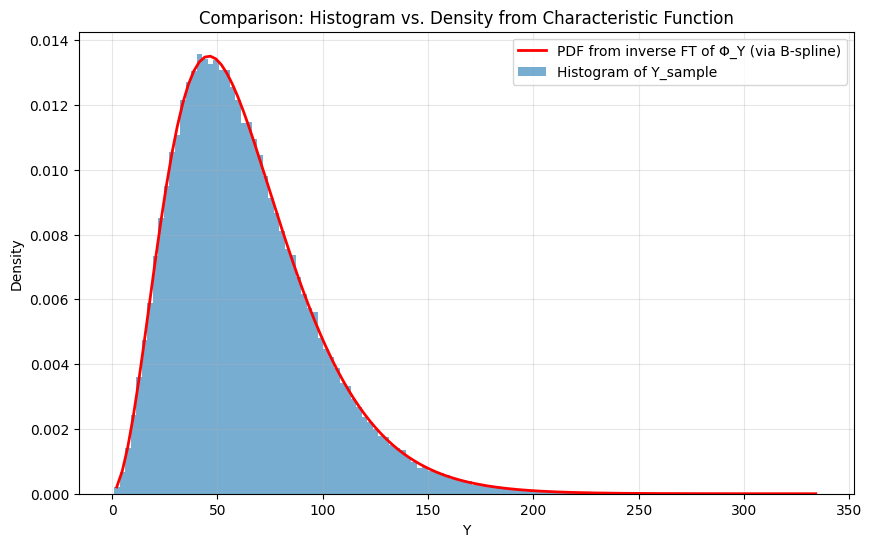

In [4]:
dim = 3

nu = np.array([3, 2, 1, 4])
A = np.array([[3, 0, 0, 0], [0, 1, 0, 0], [0, 0, 2, 0], [0, 0, 0, 1]])
C = np.array([[2.3, 0, 0, 0], [0, 2, 0, 0], [0, 0, 1, 0], [0, 0, 0, 3]])

# A = np.array([[ 2.5       ,  0.        , -0.5       ],
#        [ 0.        ,  0.5       , -0.        ],
#        [-0.5       ,  0.        ,  0.16666667]])

# nu = np.array([0, 0, 0])
# C = np.array([[1.        , 0.        , 0.77459667],
#        [0.        , 1.        , 0.        ],
#        [0.77459667, 0.        , 1.        ]]) * 1e-3

# nu = np.random.uniform(size=dim)
# A = np.random.randn(dim, dim)
# A = np.dot(A.T, A) + np.eye(dim) * 1e-6
# C = np.random.randn(dim, dim)
# C = np.dot(C.T, C) + np.eye(dim) * 1e-6

sample_N = 2 ** 17
X_sample = np.random.multivariate_normal(nu, C, size=sample_N)
Y_sample = np.array([X @ (A @ X) for X in X_sample])

pdf_spl, cdf_spl = ComputeNCGenChi2(A, nu, C, Y_sample=Y_sample, dx_factor=2**14, max_factor=2**6)

## Quadrature Weights Fluctuations

- Let's define the *moment-orthogonal* polynomials as

$$\langle q_{n}^{\left(k\right)}\left(\xi\right)\xi^{p}\rangle_{\omega}=\delta_{pk},\qquad p\leq n,$$
$$q_{n}^{\left(k\right)}\left(\xi\right)=\sum_{m=0}^{n}\alpha_{m}^{\left(k\right)}\xi^{m},\qquad \alpha_{r}^{\left(k\right)}=\left[\mathrm{H}^{\left(n\right)}\right]_{rk}^{-1},$$

- Let's define the fluctuating weights

$$\hat{w}_{i}=\frac{w_{i}}{Z}\exp\left[\sum_{p=0}^{n}q_{n}^{\left(p\right)}\left(\xi_{i}\right)\delta m_{p}\right]$$

with the normalization that can be expanded to second order

$$\begin{split}&Z=\sum_{i=1}^{N}w_{i}\exp\left[\sum_{p=0}^{n}q_{n}^{\left(p\right)}\left(\xi_{i}\right)\delta m_{p}\right]\simeq\sum_{i=1}^{N}w_{i}\left(1+\sum_{p=0}^{n}q_{n}^{\left(p\right)}\left(\xi_{i}\right)\delta m_{p}+\frac{1}{2}\sum_{r,s=0}^{n}q_{n}^{\left(r\right)}\left(\xi_{i}\right)q_{n}^{\left(s\right)}\left(\xi_{i}\right)\delta m_{r}\delta m_{s}\right)\\&=\langle1\rangle_{w}+\sum_{p=0}^{n}\langle q_{n}^{\left(p\right)}\left(\xi_{i}\right)\rangle_{w}\delta m_{p}+\frac{1}{2}\sum_{r,s=0}^{n}\langle q_{n}^{\left(r\right)}\left(\xi_{i}\right)q_{n}^{\left(s\right)}\left(\xi_{i}\right)\rangle_{w}\delta m_{r}\delta m_{s}\\&=1+\delta m_{0}+\frac{1}{2}\sum_{r,s=0}^{n}\alpha_{r}^{\left(s\right)}\delta m_{r}\delta m_{s}=1+\frac{1}{2}\sum_{r,s=1}^{n}\left[\mathrm{H}^{\left(n\right)}\right]_{rs}^{-1}\delta m_{r}\delta m_{s},\qquad\delta m_{0}=0\end{split}$$

yielding

$$Z\simeq1+\frac{1}{2}\sum_{r,s=1}^{n}\left[\mathrm{H}^{\left(n\right)}\right]_{rs}^{-1}\delta m_{r}\delta m_{s}$$

- Let's look at the logarithm of the weights

$$\log\hat{w}_{i}=-\frac{1}{2}\sum_{r,s=1}^{n}\left[\mathrm{H}^{\left(n\right)}\right]_{rs}^{-1}\delta m_{r}\delta m_{s}+\sum_{p=1}^{n}q_{n}^{\left(p\right)}\left(\xi_{i}\right)\delta m_{p}+\log w_{i}$$

$$\begin{split}&Y=\mathbf{X}^{\top}A\mathbf{X}=\sum_{k=1}^{n}\lambda_{k}U_{k}^{2},\qquad\mathbf{X}\sim\mathcal{N}\left(\boldsymbol{\nu},C\right),\qquad U_{k}\sim\mathcal{N}\left(\eta_{k},1\right),\qquad\eta_{k}=P_{kr}^{\top}S_{rs}^{-1}\nu_{s},\qquad S=\left[C\right]^{1/2},\qquad S^{\top}AS=P\Gamma P^{\top}\\&\phi_{Y}\left(t\right)=\prod_{k=1}^{n}\phi_{\lambda_{k}Z^{2}}\left(t\right)=\prod_{k=1}^{n}\frac{1}{\sqrt{1-2\imath\lambda_{k}t}}\exp\left(\frac{\imath\lambda_{k}\eta_{k}^{2}t}{1-2\imath\lambda_{k}t}\right)\end{split}$$

## Gaussian Quadratures - $p(\hat{w})$

w_i: [0.01125741 0.22207592 0.53333333 0.22207592 0.01125741]
hat_x_i: [-2.85697001 -1.35562618  0.          1.35562618  2.85697001]
kBT_max: 0.030618621784789732


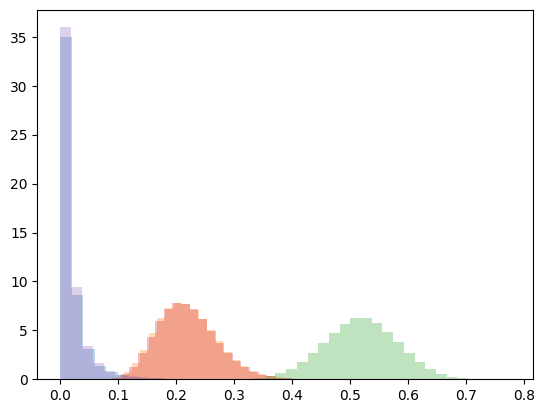

In [5]:
def GaussMs(k):
    if k == 0:
        return 1.0
    if k % 2 == 1:
        return 0
    else:
        return float(sp.factorial2(k - 1))

q_degree = 4
"""
Quadrature first, hat_x_i, w_i ... what a waste
"""
gauss_degree = q_degree + 1

H = np.array([[GaussMs(i + j) for j in range(gauss_degree + 1)] for i in range(gauss_degree + 1)])
Hm1_T = np.linalg.inv(H).T

q_polys_c = np.array([Hm1_T @ np.array([1 if j == i else 0 for j in range(gauss_degree + 1)]) for i in range(gauss_degree + 1)])
q_polys_c_np = np.array([np.flip(cs) for cs in q_polys_c])
orthogonal_poly_cs = q_polys_c_np[-1]

hat_x_i = np.sort(np.roots(orthogonal_poly_cs))

VMM = np.array([[x ** p for p in range(gauss_degree)] for x in hat_x_i])
VMM_det = np.linalg.det(VMM)
VMM_i = lambda i: np.array([H[0,:gauss_degree] if i == j else [x ** p for p in range(gauss_degree)]for j, x in enumerate(hat_x_i)])
VMM_i_det = lambda i: np.linalg.det(VMM_i(i))

w_i = np.array([VMM_i_det(i) / VMM_det for i in range(gauss_degree)])

print("w_i:", w_i)
print("hat_x_i:", hat_x_i)

"""
Moment-orthogonal polynomials
"""
H = np.array([[GaussMs(i + j) for j in range(q_degree + 1)] for i in range(q_degree + 1)])
Hm1_T = np.linalg.inv(H).T

q_polys_c = np.array([Hm1_T @ np.array([1 if j == i else 0 for j in range(q_degree + 1)]) for i in range(q_degree + 1)])
q_polys_c_np = np.array([np.flip(cs) for cs in q_polys_c])

q_polys_lams = [lambda x, c=cs: np.polyval(c, x) for cs in q_polys_c_np]
q_poly_evals = np.array([f(hat_x_i) for f in q_polys_lams])
q_poly_evals_T = q_poly_evals.T

"""
Preparing the correlations for the Moment Lattice Model
"""
def GetCpq(P, ms_lam):
    ms_dict_P = {p: ms_lam(p) for p in range(1, 2 * P + 1, 1)}
    num_lam = lambda p, q: ms_dict_P[p + q] - ms_dict_P[p] * ms_dict_P[q]
    den_lam = lambda p, q: np.sqrt((ms_dict_P[2 * p] - (ms_dict_P[p] ** 2)) * (ms_dict_P[2 * q] - (ms_dict_P[q] ** 2)))
    Cpq = np.array([[num_lam(p, q) / den_lam(p, q) for q in range(1, P + 1)] for p in range(1, P + 1)])
    return Cpq

Cpq = GetCpq(q_degree, GaussMs)

def FindMaxKBT(P, ms_lam, GL_ratio=0.1):
    ratios_mm2 = np.array([ms_lam(p) / np.sqrt((ms_lam(2 * p) - (ms_lam(p) ** 2))) for p in range(1, P + 1)])
    ratios_mm2 = ratios_mm2[ratios_mm2 > 0]
    beta_min = 1 / np.sort(ratios_mm2)[0]
    kBT_max = (1 / beta_min) * GL_ratio

    return kBT_max

kBT_max = FindMaxKBT(q_degree, GaussMs)

print("kBT_max:", kBT_max)

def SqrtVar(p, ms_lam, kBT=1):
    return np.sqrt(kBT * (ms_lam(2 * p) - (ms_lam(p) ** 2)))

def GetDeltaMs(Cpq, ms_lam, kBT, size=1):
    P_ms = Cpq.shape[0]
    phi_p = np.array(np.random.multivariate_normal([0] * P_ms, Cpq, size=size).squeeze())
    return np.array([0] + list(phi_p * np.array([SqrtVar(p, ms_lam, kBT) for p in range(1, P_ms + 1)])))

def HatWRnd(Cpq, ms_lam, kBT, size=1):
    hat_w_i = w_i * np.exp(q_poly_evals_T @ GetDeltaMs(Cpq, ms_lam, kBT, size=size))
    return hat_w_i / np.sum(hat_w_i)

kBT, n_hat_samples = kBT_max * 0.5, 2 ** 17
hat_w_sample = np.array([HatWRnd(Cpq, GaussMs, kBT) for k in range(n_hat_samples)])

sqrt_kBT_scale = np.diag(np.array([SqrtVar(p, GaussMs, kBT) for p in range(1, q_degree + 1)]))
Hm1_T_pruned = Hm1_T[1:, 1:]
H_pruned = H[1:, 1:]

AC_m = (Hm1_T_pruned @ (sqrt_kBT_scale @ Cpq @ sqrt_kBT_scale))
Lambda, Q = np.linalg.eig(AC_m)

A_inv = np.linalg.inv(Hm1_T_pruned)
etas = - Q.T @ A_inv @ q_poly_evals[1:,:]

# etas = - Q.T @ H_pruned @ q_poly_evals[1:,:]

plt.figure()

for i in range(len(w_i)):
    _ = plt.hist((hat_w_sample[:, i]), density=True, bins=2**5, alpha=0.3)
    
# plt.yscale('log')
# plt.xscale('log')


--- Processing weight 0 (nominal w_i[0] = 0.0113) ---


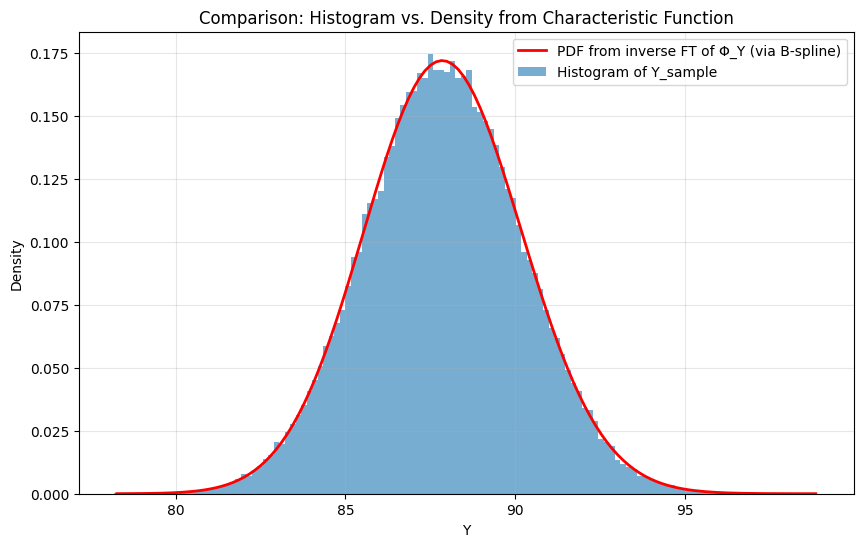

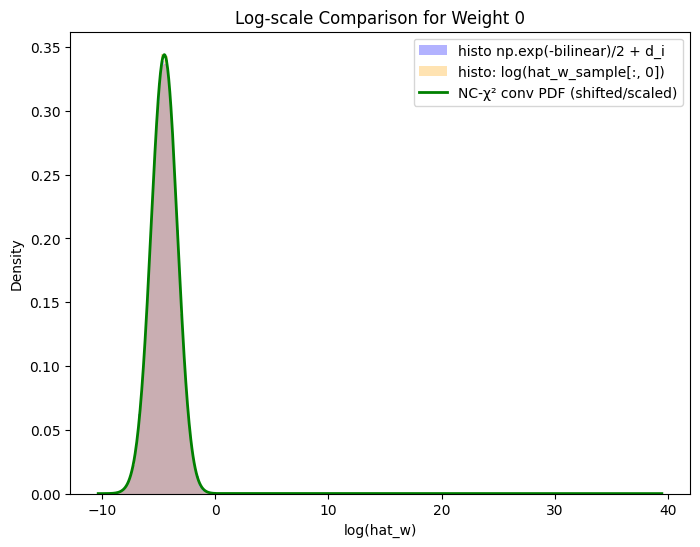

  Max pdf_w_vals: 20.00 (should be ~5-10 for inners)


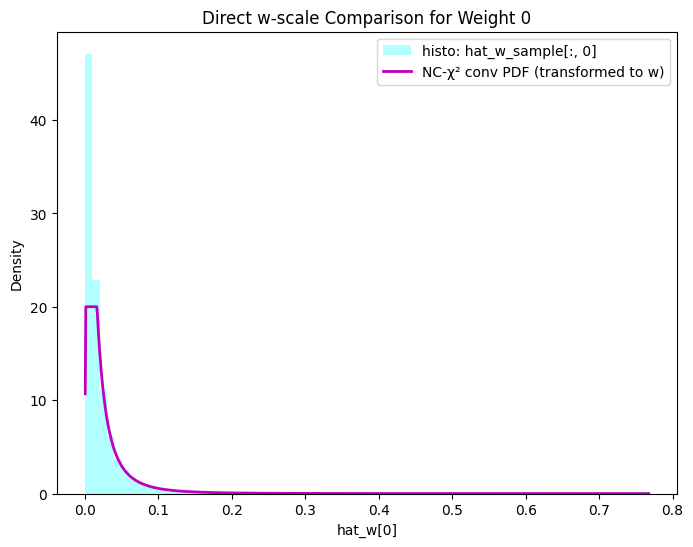


--- Processing weight 1 (nominal w_i[1] = 0.2221) ---


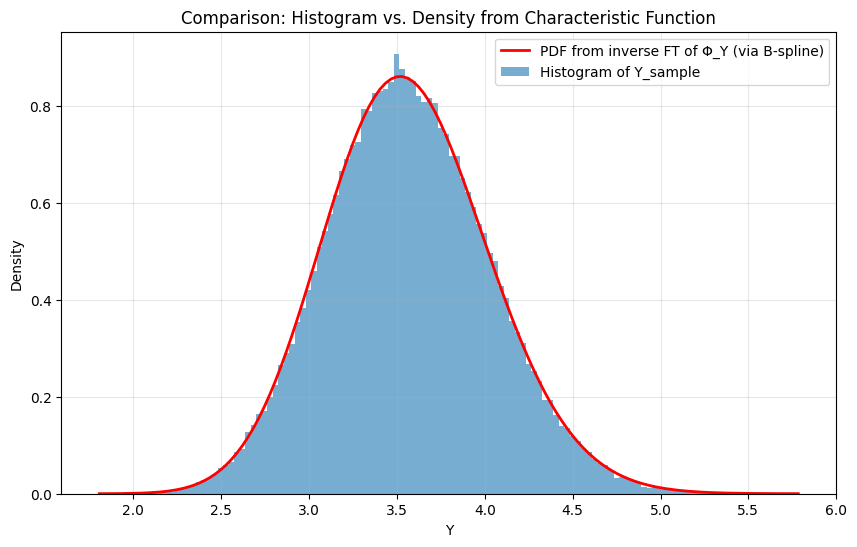

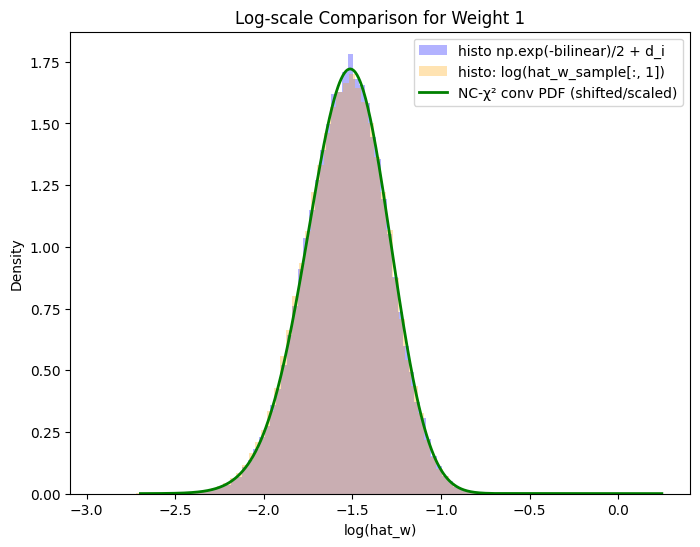

  Max pdf_w_vals: 8.02 (should be ~5-10 for inners)


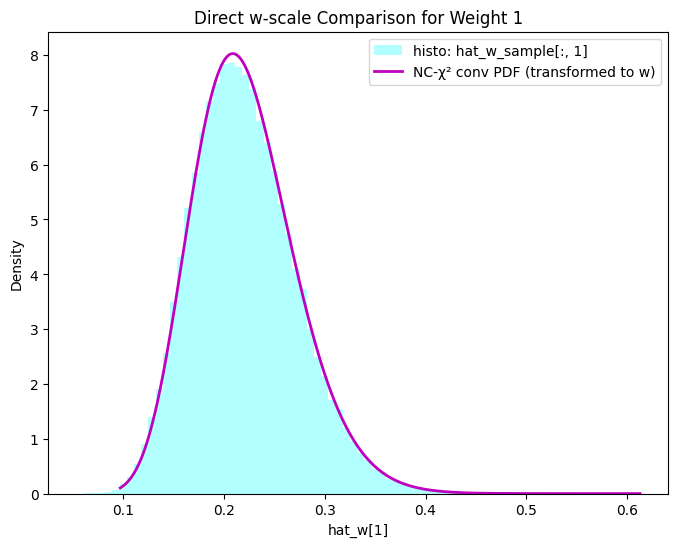


--- Processing weight 2 (nominal w_i[2] = 0.5333) ---


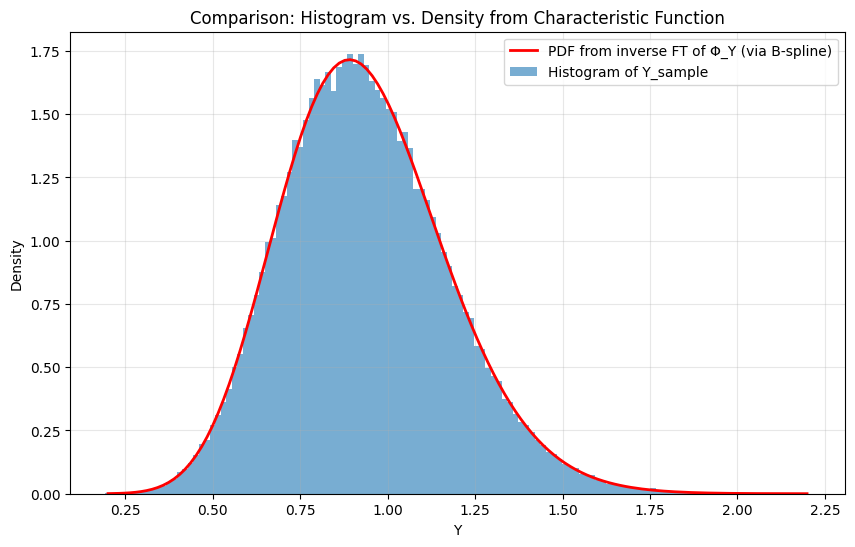

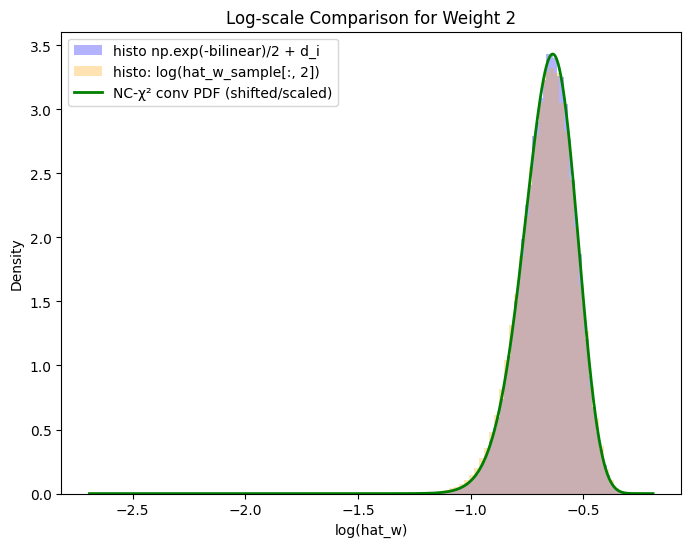

  Max pdf_w_vals: 6.53 (should be ~5-10 for inners)


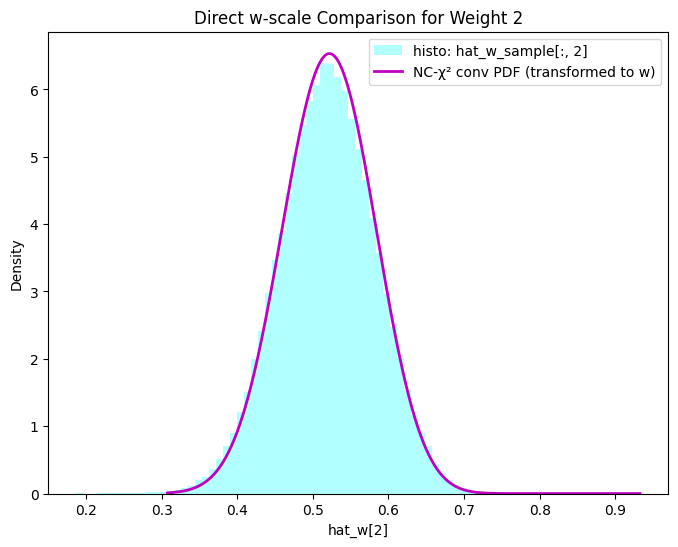


--- Processing weight 3 (nominal w_i[3] = 0.2221) ---


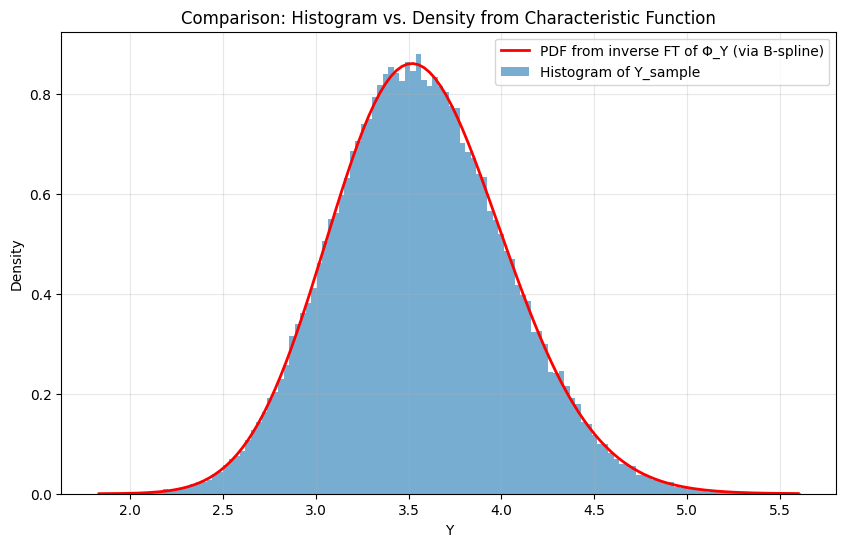

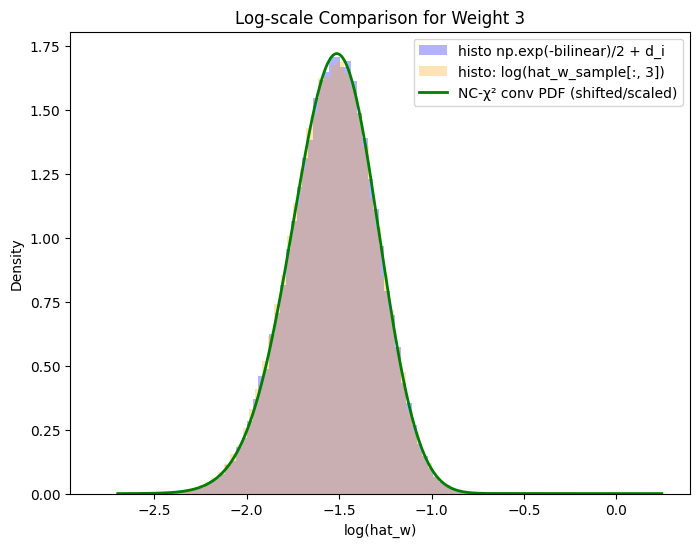

  Max pdf_w_vals: 8.03 (should be ~5-10 for inners)


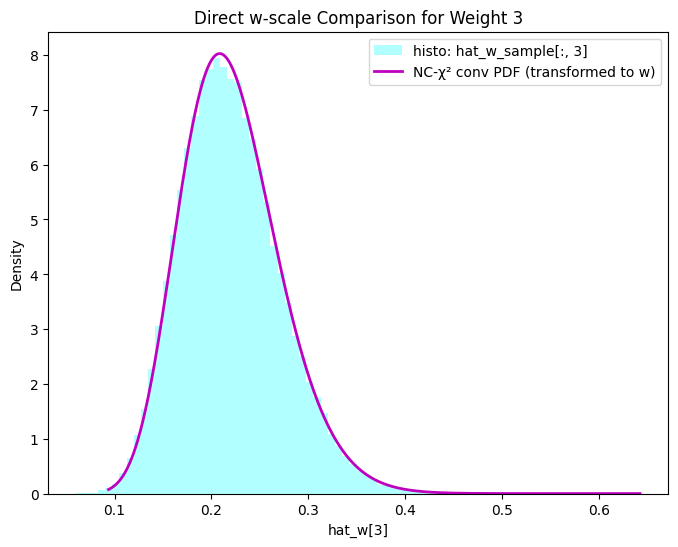


--- Processing weight 4 (nominal w_i[4] = 0.0113) ---


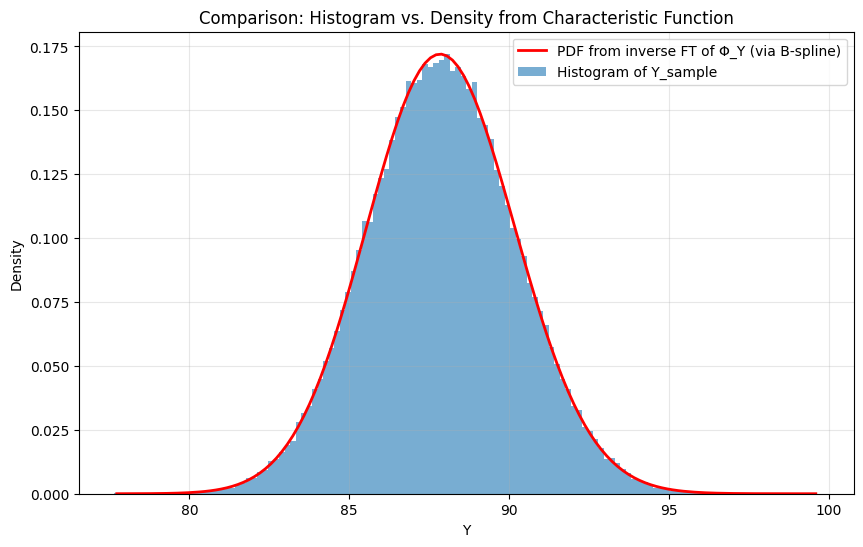

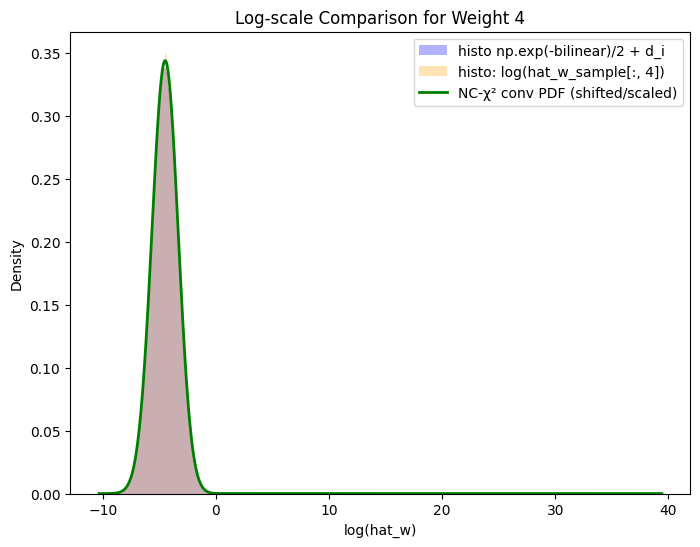

  Max pdf_w_vals: 20.00 (should be ~5-10 for inners)


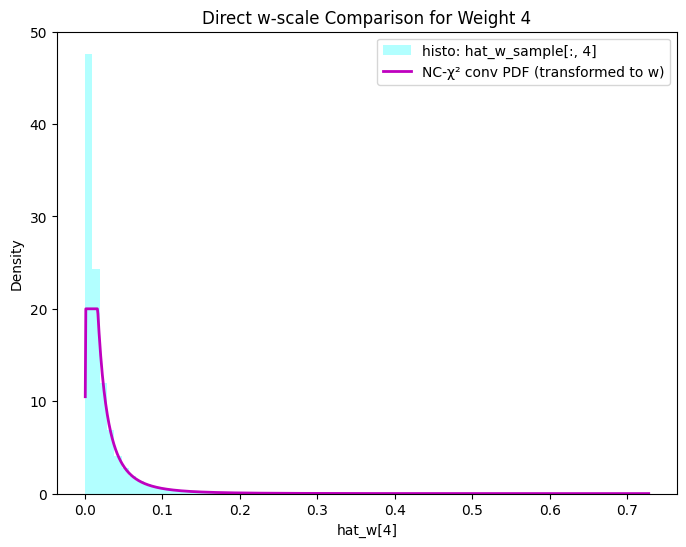

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.stats import percentileofscore  # For percentile, but use np.percentile

# Shared computations (outside loop)
N_delta_ms = 2 ** 17
delta_ms = np.array([GetDeltaMs(Cpq, GaussMs, kBT) for _ in range(N_delta_ms)])
P = Hm1_T[1:, 1:]  # Precision block: inv(Γ_pruned)
Gamma_pruned = np.linalg.inv(P)  # Cov block for shifts
C = sqrt_kBT_scale @ Cpq @ sqrt_kBT_scale  # Already 3x3
delta_pruned = delta_ms[:, 1:]  # Shape (N, 3), shared

# Loop over all weights (i=0 to 3)
for i in range(len(w_i)):
    print(f"\n--- Processing weight {i} (nominal w_i[{i}] = {w_i[i]:.4f}) ---")
    
    # Per-weight computations
    v_i = q_poly_evals[:, i]  # All polys evals at x_i
    v_pruned = v_i[1:]  # Pruned (powers 1-3 at x_i)
    mu_pruned = Gamma_pruned @ v_pruned  # Optimal shift in pruned space
    d_i_val = 0.5 * np.dot(v_pruned, mu_pruned) + np.log(w_i[i])  # ½ v^T Γ v + log w_i
    
    # Quadratic form samples for this i
    bilinear_sample = np.array([
        np.dot(delta_p - mu_pruned, P @ (delta_p - mu_pruned))
        for delta_p in delta_pruned
    ])
    
    # Compute NC-χ² PDF (bump max_factor for inners to fatten tail sampling)
    max_factor_i = 2**7 if i in [1, 2] else 2**6  # Extra tail buffer for central nodes
    tck_pdf, tck_cdf = ComputeNCGenChi2(
        A=P, nu=-mu_pruned, C=C,
        Y_sample=bilinear_sample,
        dx_factor=2**14, max_factor=max_factor_i
    )
    bs_pdf = BSpline(*tck_pdf)
    
    # Log-scale comparison
    y_mean, y_std = np.mean(bilinear_sample), np.std(bilinear_sample)
    y_min, y_max = 0, max(5, y_mean + 5 * y_std)
    y_grid = np.linspace(y_min, y_max, 2**10)
    log_w_grid = -y_grid / 2 + d_i_val
    pdf_vals = 2 * np.maximum(bs_pdf(y_grid), 0)  # Jac + nonneg clip
    
    plt.figure(figsize=(8, 6))
    _ = plt.hist(-bilinear_sample / 2 + d_i_val, density=True, bins=2**6, alpha=0.3, 
                 label="histo np.exp(-bilinear)/2 + d_i", color='blue')
    _ = plt.hist(np.log(hat_w_sample[:, i]), density=True, bins=2**6, alpha=0.3, 
                 label=f"histo: log(hat_w_sample[:, {i}])", color='orange')
    plt.plot(log_w_grid, pdf_vals, 'g-', linewidth=2, label="NC-χ² conv PDF (shifted/scaled)")
    plt.xlabel('log(hat_w)')
    plt.ylabel('Density')
    plt.title(f'Log-scale Comparison for Weight {i}')
    plt.legend()
    plt.show()
    
    # Direct w-scale comparison (with safeguards against divergence)
    w_samples = hat_w_sample[:, i]
    w_mean, w_std = np.mean(w_samples), np.std(w_samples)
    w_min_safe = max(np.min(w_samples) * 0.5, np.percentile(w_samples, 0.1))  # Avoid extreme low; use 10th percentile floor
    w_max = np.max(w_samples) * 1.2
    w_grid = np.linspace(w_min_safe, w_max, 2**10)
    z_grid = np.log(w_grid)
    y_for_z = -2 * (z_grid - d_i_val)  # Y corresponding to each z
    # Clip y_for_z to bs_pdf support to avoid extrapolation artifacts
    y_support_max = y_mean + 8 * y_std  # Conservative tail
    y_for_z = np.clip(y_for_z, 0, y_support_max)
    pdf_z_vals = 2 * np.maximum(bs_pdf(y_for_z), 0)  # f_Z(z)
    pdf_w_vals = pdf_z_vals / w_grid  # Jacobian for exp: /w
    pdf_w_vals = np.clip(pdf_w_vals, 0, 20)  # Cap at reasonable density (e.g., 20x peak hist) to kill spikes
    
    print(f"  Max pdf_w_vals: {np.max(pdf_w_vals):.2f} (should be ~5-10 for inners)")
    
    plt.figure(figsize=(8, 6))
    _ = plt.hist(w_samples, density=True, bins=2**6, alpha=0.3, label=f"histo: hat_w_sample[:, {i}]", color='cyan')
    plt.plot(w_grid, pdf_w_vals, 'm-', linewidth=2, label="NC-χ² conv PDF (transformed to w)")
    plt.xlabel(f'hat_w[{i}]')
    plt.ylabel('Density')
    plt.title(f'Direct w-scale Comparison for Weight {i}')
    plt.legend()
    plt.show()